In [46]:
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from adjustText import adjust_text

from scipy import stats
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [47]:
datadir = '../data/dnaPipeTE-out'
dnapipete_data = {sp: f'{datadir}/{sp}/Counts.txt' for sp in os.listdir(datadir)}

In [48]:
def read_counts(countfile):
    count_df = pd.read_csv(countfile, sep='\t', header=None, names=['teclass', 'readcount'])
    return count_df

def count_finz(species):
    count = 0
    with open('../data/seqs/cypriniformes_augustus_finz.fa') as infile:
        for line in infile:
            if line.startswith(f'>{species}'):
                count += 1
    return count

In [49]:
count_dfs = []
for sp, val in dnapipete_data.items():
    count_df = read_counts(val)
    count_df['species'] = sp
    count_df['finz'] = count_finz(sp)
    count_dfs.append(count_df)

count_df = pd.concat(count_dfs)
count_df = count_df.pivot_table(index=['species', 'finz'], 
                                columns='teclass', 
                                values='readcount') \
    .sort_values('finz') \
    .reset_index()
count_df['Unknown'] = count_df.na + count_df.others
count_df = count_df.drop(['Others', 'Tandem_repeats', 'na', 'others', 'rRNA', 'MITE', 'Simple_repeat'], axis=1)
count_df['interspersed'] = count_df.DNA + count_df.LTR + count_df.LINE + count_df.SINE + count_df.Helitron
for teclass in ['DNA', 'Helitron', 'LINE', 'LTR', 'SINE', 'Low_Complexity', 'Satellite', 'Unknown', 'interspersed', 'Total']:
    count_df[teclass] = count_df[teclass]/count_df['Total']*100 

print(count_df)

teclass                       species  finz        DNA  Helitron      LINE  \
0                Triplophysa_tibetana     0  11.535100  0.353564  4.109580   
1              Triplophysa_siluroides     0  11.144761  0.165809  2.899348   
2                  Danionella_dracula     0   5.642604  0.563075  3.757688   
3              Danionella_translucida     4   7.711250  1.695768  2.048340   
4          Poropuntius_huangchuchieni     8   9.116787  0.203333  1.180123   
5         Hypophthalmichthys_molitrix    31   9.461421  0.298279  0.607438   
6                 Pimephales_promelas    32  17.983488  0.346771  1.834706   
7               Cirrhinus_molitorella    41  16.660372  0.722617  1.050370   
8                       Danio_choprai    70  21.868231  0.889300  2.841165   
9                  Leuciscus_waleckii    76  14.372370  0.252140  2.151607   
10         Hypophthalmichthys_nobilis    85  14.669671  0.534938  0.932868   
11                Danio_jaintianensis    93  24.692450  1.007389

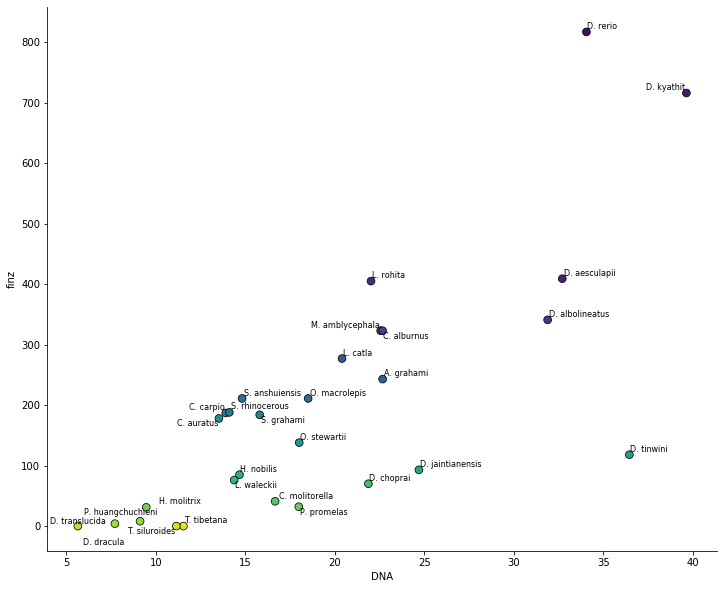

SpearmanrResult(correlation=0.7586888936488223, pvalue=1.8474137731381845e-06)


In [50]:
column = 'DNA'
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(data=count_df, 
                x=column, 
                y='finz',
                hue='species',
                palette='viridis_r',
                edgecolor='k',
                s=60,
                ax=ax)
ax.get_legend().remove()

labels = []
for row in count_df.iterrows():
    label = row[1]['species'].split('_')[0][0] +'. '+ row[1]['species'].split('_')[1]
    labels.append(ax.text(row[1][column], row[1]['finz'], label, size=8, va='center', ha='center'))
adjust_text(labels)

sns.despine()
plt.show()
print(stats.spearmanr(count_df[column], 
                      count_df['finz']))

In [41]:
y = count_df['DNA'].values.reshape(-1, 1) 
X = count_df['LTR'].values.reshape(-1, 1) 
lm = LinearRegression().fit(y, X)

count_df['pred_LTR'] = lm.predict(y).reshape(-1, 1)
count_df['resid_LTR'] = count_df['LTR'] - count_df['pred_LTR']


[0.58076044 0.15320312 0.1401168  0.07644073 0.02857496 0.02090396]


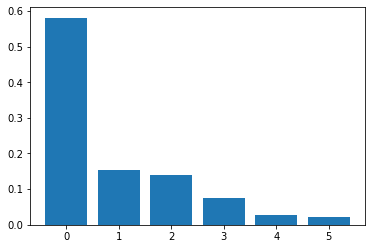

In [33]:
features = ['finz', 'DNA', 'LTR', 'LINE', 'SINE', 'Helitron']
X = count_df[features].values
sc = StandardScaler() 
X = sc.fit_transform(X)
pca = PCA()
pca.fit(X)
explained_variance = pca.explained_variance_ratio_ 
plt.bar(x=range(len(explained_variance)), height=explained_variance)
print(explained_variance)